# Compute the temporal average over a multi-file dataset and plot the result on a map

This example shows how to compute a temporal average on a CMIP6 dataset and then plot the analysis result on a map. 

The notebook will exploit:
- an **intake** catalog to search and discover CMIP6 data
- **xarray** to compute the climate index
- **Cartopy** and **Matplotlib** to plot the results.

Make sure to select **Python [conda env:climate]** as Notebook Kernel.

Import the main Python modules

In [29]:
import os, intake
import dask
import fsspec
import xarray as xr
import numpy as np
import pandas as pd
import ipywidgets as widgets

Climate datasets are stored on the OpenStack Swift instance deployed at DKRZ premises.
We can use the **intake-esm** (https://github.com/intake/intake-esm) data cataloging utility to search, discover, access and load data.

**Open an ESM (Earth System Model) collection definition file**: intake-esm will use it to establish a link to a database (CSV file) that contains data assets locations and associated metadata.

The ESM collection file is located at **https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a8a-9f25-a6cb8924d92b/CMCC_CMIP/catalog.json**.

We can inspect the ESM collection file to get unique values for models, experiments and variables in the catalog.

In [2]:
col = intake.open_esm_datastore("https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a8a-9f25-a6cb8924d92b/CMCC_CMIP/catalog.json")
uniques = col.unique(columns=["source_id","experiment_id","variable_id"])
uniques

{'source_id': {'count': 3,
  'values': ['CMCC-CM2-SR5', 'CMCC-ESM2', 'CMCC-CM2-HR4']},
 'experiment_id': {'count': 3, 'values': ['ssp245', 'ssp585', 'historical']},
 'variable_id': {'count': 4, 'values': ['tas', 'tasmax', 'pr', 'tasmin']}}

**Search and Discovery**: execute a search query against the catalog

For example, we are interested in:
  - CMCC datasets about the **CMCC-CM2-SR5** model
  - **tas** variable
  - **ALL** the experiments

In [3]:
query = dict(
             source_id="CMCC-CM2-SR5", 
             variable_id="tas"
)
cat = col.search(**query)
cat.df

prefix  \
0  CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1...   
1  CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.r1i...   
2  CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.r1i...   

                                                 url mip_era  activity_id  \
0  https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a...   CMIP6         CMIP   
1  https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a...   CMIP6  ScenarioMIP   
2  https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a...   CMIP6  ScenarioMIP   

  institution_id     source_id experiment_id member_id table_id variable_id  \
0           CMCC  CMCC-CM2-SR5    historical  r1i1p1f1      day         tas   
1           CMCC  CMCC-CM2-SR5        ssp245  r1i1p1f1      day         tas   
2           CMCC  CMCC-CM2-SR5        ssp585  r1i1p1f1      day         tas   

  grid_label    version  
0         gn  v20200616  
1         gn  v20200617  
2         gn  v20200622

The output above shows that the catalog includes three datasets matching the search criteria. Each dataset corresponds to a specific experiment: **historical**, **ssp245**, **ssp585**.

**Access**: when you are satisfied with the results of your query, you can ask intake-esm to load data assets into xarray datasets. To do this, we use the **to_dataset_dict** function.

In [5]:
xrdsetdict = cat.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'prefix.url.mip_era.activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version'


Get histotical dataset

In [8]:
historical = [key for key in xrdsetdict.keys() if "historical" in key][0]
dshist = xrdsetdict[historical]
dshist

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, time: 60225)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(471, 192, 288), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(30113, 1), meta=np.ndarray>
Attributes: (12/49)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    cmor_version:            3.5.0
    ...                      ...
    title:                   CMCC-CM2-SR5 output prepared for CMIP6
    tracking_id:             acf33743-8b7f-44c1-8ce9-fbfde1746b72
    variable_id:             tas
    variant_label:           r1i1p1f1
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1...

Perform a temporal mean on a specific time range

In [12]:
start=2000
end=2015

tashist = dshist.sel(time=dshist.time.dt.year.isin(range(start, end)))

globalmean = tashist.mean(dim='time')
globalmean_var = globalmean.tas.values
globalmean_lat = globalmean.lat.values
globalmean_lon = globalmean.lon.values
globalmean

<xarray.Dataset>
Dimensions:   (lat: 192, bnds: 2, lon: 288)
Coordinates:
    height    float64 ...
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    tas       (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>

Plot the results on a map

In [10]:
def plot_results(var,lat,lon):
    %matplotlib inline
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.util import add_cyclic_point
    import numpy as np
    import warnings
    warnings.filterwarnings("ignore")

    fig = plt.figure(figsize=(15, 6), dpi=100)

    #Add Geo axes to the figure with the specified projection (PlateCarree)
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)

    #Draw coastline and gridlines
    ax.coastlines()
    gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=1, color='black', alpha=0.9, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False

    var = np.reshape(var, (len(lat), len(lon)))

    #Wraparound points in longitude
    var_cyclic, lon_cyclic = add_cyclic_point(var, coord=lon)
    x, y = np.meshgrid(lon_cyclic,lat)

    #Define color levels for color bar
    levStep = (np.max(var)-np.min(var))/20
    clevs = np.arange(np.min(var),np.max(var)+levStep,levStep)

    #Set filled contour plot
    cnplot = ax.contourf(x, y, var_cyclic, clevs, transform=projection,cmap=plt.cm.jet)
    plt.colorbar(cnplot,ax=ax)

    ax.set_aspect('auto', adjustable=None)
    plt.title('tas average (deg K)')
    plt.show()

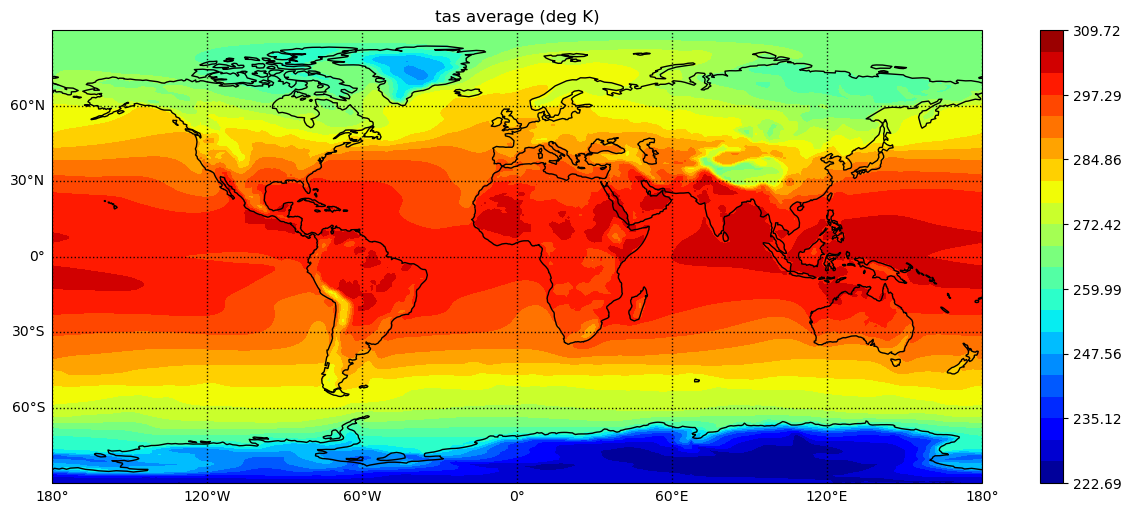

In [11]:
plot_results(globalmean_var,globalmean_lat,globalmean_lon)

As another example, we can perform a temporal mean on yearly basis. Here we use: 
  - the [**open_zarr**](https://docs.xarray.dev/en/stable/generated/xarray.open_zarr.html) function provided by xarray to load and decode a dataset from a Zarr store,
  - [**xarray.DataArray.groupby**](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html) to perform a grouped operation (on yearly basis),
  - [**xarray.DataArray.mean**](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.mean.html) to reduce the DataArray’s data by applying mean along the time dimension.

In [13]:
query = dict(
             source_id="CMCC-CM2-SR5", 
             variable_id="tas",
            experiment_id="historical"
)
cat = col.search(**query)
selected_path = cat.df["url"][0]
selected_path

'https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a8a-9f25-a6cb8924d92b/CMCC_CMIP/CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1.day.tas.gn.v20200616'

In [14]:
%%time
fsmap = fsspec.get_mapper(selected_path)
mean_values = xr.open_zarr(fsmap, consolidated=True)['tas'].groupby("time.year").mean()
mean_values

CPU times: user 907 ms, sys: 16.1 ms, total: 923 ms
Wall time: 1.76 s


<xarray.DataArray 'tas' (year: 165, lat: 192, lon: 288)>
dask.array<stack, shape=(165, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014

We can then select a specific year (check values for the *year* dimension in the output above) and plot the result on a map

In [15]:
mean_values = mean_values.sel(year=2000)
mean_values_var = mean_values.values
mean_values_lat = mean_values['lat'].values
mean_values_lon =mean_values['lon'].values

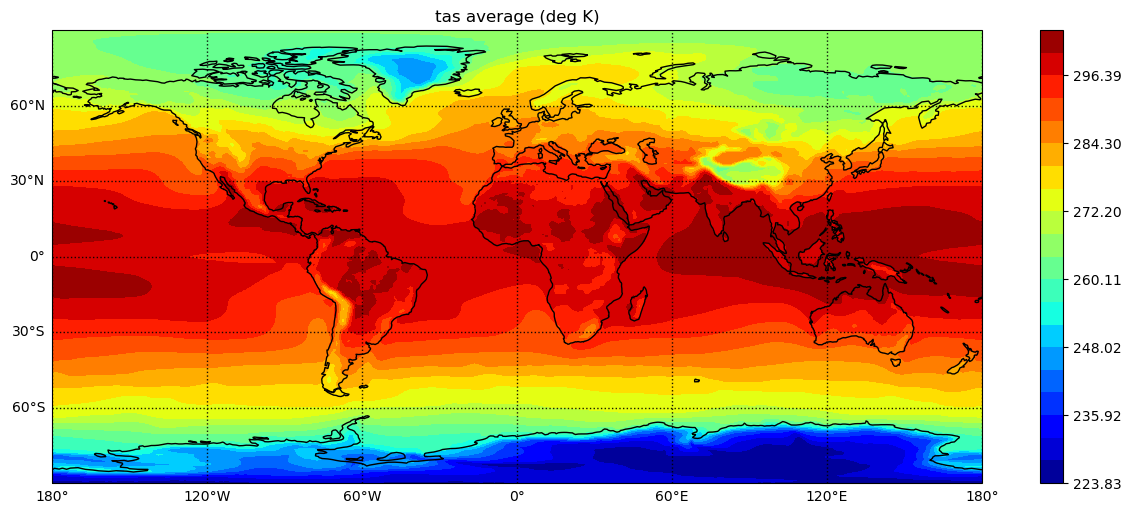

In [16]:
plot_results(mean_values_var,mean_values_lat,mean_values_lon)

# Compute the ETR - Extreme Temperature Range

The second example shows how to compute the Extreme Temperature Range climate index for the same CMIP6 dataset used in the previous use case.

Let TXx be the daily maximum temperature in month k and TNn the daily minimum temperature in month k. The Extreme Temperature Eange for each month is then:

\begin{equation*} 
ETR(k) = TXx(k) − TNn(k)
\end{equation*}


The CMIP6 datasets available on the OpenStack Swift instance also include files related to the **tasmin** (Daily Minimum Near-Surface Air Temperature) and **tasmax** (Daily Maximum Near-Surface Air Temperature) variables, as we can see by inspecting the catalog

In [17]:
col.unique(columns=["variable_id"])

{'variable_id': {'count': 4, 'values': ['tas', 'tasmax', 'pr', 'tasmin']}}

Retrieve the available models and experiments for *tasmin/tasmax* variables

In [18]:
models = col.df[(col.df['variable_id']=='tasmin')]['source_id'].unique().tolist()
experiments = col.df[(col.df['variable_id']=='tasmin')]['experiment_id'].unique().tolist()
print("Models: "+str(models))
print("Experiments: "+str(experiments))

Models: ['CMCC-ESM2']
Experiments: ['historical', 'ssp245']


For each variable, execute a query against the catalog to retrieve entries satisfyng the search criteria. For example, we are interested in:

  - **CMCC-ESM2** model
  - **historical** experiment

In [19]:
# Select tasmin
query = dict( experiment_id="historical",
             source_id="CMCC-ESM2", 
             variable_id="tasmin"
)
cat_min = col.search(**query)
paths_min=cat_min.df["url"][0]
print("\ntasmin paths:")
print(paths_min)

# Select tasmax
query = dict( experiment_id="historical",
             source_id="CMCC-ESM2", 
             variable_id="tasmax"
)
cat_max = col.search(**query)
paths_max=cat_max.df["url"][0]
print("\ntasmax paths:")
print(paths_max)


tasmin paths:
https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a8a-9f25-a6cb8924d92b/CMCC_CMIP/CMIP6.CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1.day.tasmin.gn.v20210114

tasmax paths:
https://swift.dkrz.de/v1/dkrz_0b2a0dcc-1430-4a8a-9f25-a6cb8924d92b/CMCC_CMIP/CMIP6.CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1.day.tasmax.gn.v20210114


Here we are going to use **Dask Delayed** (https://examples.dask.org/applications/embarrassingly-parallel.html) to parallelize embarrassingly parallel workloads and make our functions lazy. 

The **lazy_results** list will contain information about two calls (*calc_max* and *calc_min*, respectively) that have not yet been run. Call **.compute()** when you want your result as normal Python objects.

The **results** object will contains two DataArray objetcs: the daily maximum temperature and the daily minimum temperature after a [resampling operation](https://xarray.pydata.org/en/v0.8.0/generated/xarray.Dataset.resample.html) over the time-series data. Specifically, an upsampling has been performed from daily to monthly resolution.

In [22]:
%%time
from dask import delayed
import xarray as xr
import fsspec

def calc_max(paths_max):
    fsmap = fsspec.get_mapper(paths_max)
    max_v = xr.open_zarr(fsmap, consolidated=True)['tasmax'].resample(time="MS").max(dim='time')
    return max_v

def calc_min(paths_min):
    fsmap = fsspec.get_mapper(paths_min)
    min_v = xr.open_zarr(fsmap, consolidated=True)['tasmin'].resample(time="MS").min(dim='time')
    return min_v

lazy_results = []

lazy_result = dask.delayed(calc_max)(paths_max)  
lazy_results.append(lazy_result)
lazy_result = dask.delayed(calc_min)(paths_min)
lazy_results.append(lazy_result)
results = dask.compute(*lazy_results)
results

CPU times: user 8.81 s, sys: 141 ms, total: 8.95 s
Wall time: 9.79 s


(<xarray.DataArray 'tasmax' (time: 1980, lat: 192, lon: 288)>
 dask.array<stack, shape=(1980, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) object 1850-01-01 00:00:00 ... 2014-12-01 00:00:00
     height   float64 ...
   * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
   * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8,
 <xarray.DataArray 'tasmin' (time: 1980, lat: 192, lon: 288)>
 dask.array<stack, shape=(1980, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) object 1850-01-01 00:00:00 ... 2014-12-01 00:00:00
     height   float64 ...
   * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
   * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8)

We can now compute the ETR index

In [24]:
ETR=results[0]-results[1]
ETR["time"] = ETR.indexes['time'].to_datetimeindex() # to convert CFTimeIndex to a pandas.DatetimeIndex
ETR

<xarray.DataArray (time: 1980, lat: 192, lon: 288)>
dask.array<sub, shape=(1980, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
    height   float64 2.0
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

As we can see from the output above (**time: 1980**), daily input data has been reduced on monthly basis.

The following cell shows in details all the values for the *time* dimension

In [25]:
ETR.time

<xarray.DataArray 'time' (time: 1980)>
array(['1850-01-01T00:00:00.000000000', '1850-02-01T00:00:00.000000000',
       '1850-03-01T00:00:00.000000000', ..., '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
    height   float64 2.0

We can now select one specific month and show the computation result

In [26]:
month = "2014-08"
ETR_one_month=ETR.sel(time=month)
ETR_one_month

<xarray.DataArray (time: 1, lat: 192, lon: 288)>
dask.array<getitem, shape=(1, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2014-08-01
    height   float64 2.0
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

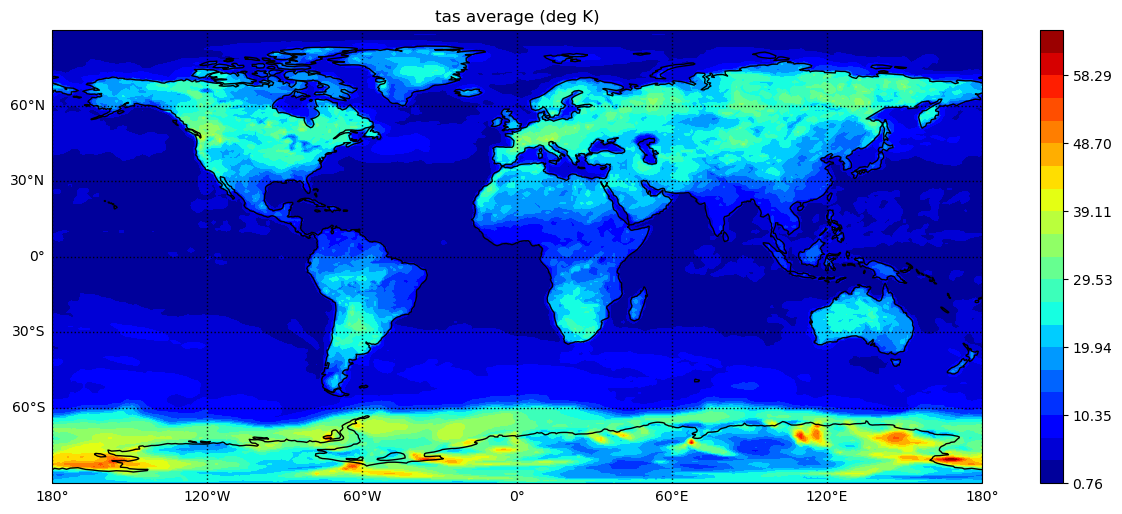

In [27]:
plot_results(ETR_one_month.values,ETR_one_month['lat'].values,ETR_one_month['lon'].values)